# Deep Metal
## Putting heavy metal into data science

### Part II: Language analysis (ENGLISH) - words, readability, "metalness", POS

The notebook contains:

- Definition of a subset made of a number of most popular bands;
- Readability analysis: swear words ratio and Coleman-Liau grade index
- Word frequence and definition of "metalness"
- Metalness index for songs, albums and artists
- POS analysis

In [205]:
%load_ext autoreload
%autoreload 2
import math
import matplotlib.pyplot as plt
import nltk
ntlk.download('punkt')
import numpy as np
import pandas as pd
import pycountry
import re
import scipy
import string

from IPython.display import display, HTML, Image, Markdown, Math
from collections import Counter
from common.graphs import plot_pie_graph, plot_vertical_bars, plot_horizontal_bars, plot_scatter, plot_connected_scatter, plot_wordcloud, printmd
from nltk import FreqDist, tokenize
from pandarallel import pandarallel
from readability.readability import Readability
from tqdm import tqdm
from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
pandarallel.initialize(progress_bar=True)
pd.options.mode.chained_assignment = None
tqdm.pandas()

NO_POPULAR_BANDS = 1000

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Datasets

- Load a reduced version of the original dataset containing only the songs in english;
- Define a subset of the previous dataset, taking the **1000 most popular bands on the dataset**, in terms of number of songs;

In [207]:
dataset_eng_df = pd.read_csv('../datasets/metal_dataset_clean_eng.csv', encoding='utf-8', sep='|') \
                    .drop(columns=['lang_iso', 'lang_name'])

songs_number = len(dataset_eng_df)
albums_number = len(np.unique(dataset_eng_df[['artist', 'album']].values))
artists_number = len(dataset_eng_df.artist.unique())

printmd(f"**SONGS:** {songs_number}")
printmd(f"**ALBUMS:** {albums_number}")
printmd(f"**ARTISTS:** {artists_number}")

dataset_eng_df.head()

**SONGS:** 195156

**ALBUMS:** 28679

**ARTISTS:** 7865

,artist,album,album_type,release_year,title,track_no,lyrics
0,'68,In Humor And Sadness,Studio,2014,Track 1 R,1,Take your heart into the next room.\nMake a sc...
1,'68,In Humor And Sadness,Studio,2014,Track 2 E,2,"It doesn't matter what you say,\nThey could al..."
2,'68,In Humor And Sadness,Studio,2014,Track 3 G,3,"Hey kid, don't listen to them.\nWe got a long,..."
3,'68,In Humor And Sadness,Studio,2014,Track 4 R,4,Stained glass.\nI wish that I could say that i...
4,'68,In Humor And Sadness,Studio,2014,Track 5 E,5,I've been taken to the edge of it all.\nI've b...


In [208]:
popular_bands = dataset_eng_df.groupby('artist')['artist'].count() \
    .reset_index(name='count').sort_values(['count'], ascending=False) \
    .reset_index().drop(columns=['index'])[:NO_POPULAR_BANDS]
popular_bands_df = dataset_eng_df[dataset_eng_df.artist.isin(list(popular_bands['artist']))]

printmd(f"**MOST POPULAR {str(NO_POPULAR_BANDS)} BANDS ({len(popular_bands_df)} songs)**")
printmd("---")

display(HTML(popular_bands.to_html()))



**MOST POPULAR 1000 BANDS (82413 songs)**

---

,artist,count
0,Judas Priest,342
1,Alice Cooper,324
2,Motorhead,292
3,Napalm Death,279
4,Rage,274
5,Unholy Grave,245
6,Saxon,232
7,W.A.S.P.,232
8,Agathocles,221
9,Venom,218


## Readability

- Statistics about swearwords in lyrics;
- Coleman-Liau grade score calculation and analysis about text complexity;
- Data visualization in tables and plots;

In [284]:
SWEAR_WORDS = [str(line.rstrip('\n')) for line in open("./common/resources/swear_words_eng.txt", "r")]
STOPWORDS = list(set([str(line.rstrip('\n')) for line in open("./common/resources/stopwords_eng.txt", "r")]))
PUNCTUATION =  list(string.punctuation) + ['..', '...', '’', "''", '``', '`']

def count_swear_word_ratio(text):
    counter = 0
    text = text.lower().replace('\\n', ' ')
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
            
    for word in SWEAR_WORDS:
        counter += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), text))
    number_of_words = len(nltk.word_tokenize(text))
    
    return counter / number_of_words

def measure_readability(text):
    text = text.replace('\\n', ' ')
    try:
        cl_grade = int(Readability(text).coleman_liau().grade_level)
    except Exception as e:
        cl_grade = 1
    
    return max(1, cl_grade)

In [264]:
popular_bands_df["swear_word_ratio"] = popular_bands_df.lyrics.parallel_apply(count_swear_word_ratio)
popular_bands_df["readability"] = popular_bands_df.lyrics.parallel_apply(measure_readability)

printmd("**Dataset with swearwords and readability coefficients**")
popular_bands_df.sample(n=5)

**Dataset with swearwords and readability coefficients**

,artist,album,album_type,release_year,title,track_no,lyrics,swear_word_ratio,readability,metalness
173531,Theatres Des Vampires,Candyland,Studio,2016,Seventh Room,10,Seven rooms as the seven sins\nParade in the a...,0.0,8,0.548352
144532,Ragnarok,Collectors Of The King,Studio,2010,Eternal Damnation,6,"So pure the passions, overwhelming the shatter...",0.0,13,0.665689
108984,Lord Of The Lost,Antagony,Studio,2011,Fragmenting Façade,4,Every day I ask you what is it for\nThough you...,0.0,2,0.539567
59171,Drakkar,Gemini,Studio,2000,Dragonship,7,All around I hear the crackling of broken ice\...,0.0,8,0.508146
56613,Dismember,Like An Ever Flowing Stream,Studio,1991,And So Is Life,4,Bitter bloodstained tears\nFilling my saddened...,0.0,8,0.607740


In [280]:
printmd("**First 5 songs with highest swearwords ratio**")
display(HTML(popular_bands_df.sort_values(['swear_word_ratio'], ascending=False)[:10].to_html()))
printmd("---")
printmd("**First 5 songs with highest Coleman-Liau score (a higher value means a more difficult text)**")
display(HTML(popular_bands_df.sort_values(['readability'], ascending=False)[:10].to_html()))

**First 5 songs with highest swearwords ratio**

,artist,album,album_type,release_year,title,track_no,lyrics,swear_word_ratio,readability,metalness
123913,The Meads Of Asphodel,Damascus Steel,Studio,2005,The Gods Who Mock Us,7,"Vishnu, Fuck, Iblis, Fuck, Elohim, Fuck, Christ, Fuck, Zeus, Fuck Ishtar,\nFuck, Isis, Fuck, Mithra, Fuck, Thunor, Fuck, Jehovah, Fuck Odin,\nfuck, Enlil, fuck, Reshep, Fuck, Allah, fuck, Indra, fuck, Buddah,\nfuck Typhon, fuck, Astaroth, fuck, Dagon, fuck, Ea, fuck, Ra, fuck,\nDonar, fuck Milcom, fuck, Teshub, fuck, Cronos, fuck, Lucifer, fuck",0.500000,1,0.312587
138792,Phobia,Grind Your Fucking Head In,EP,2003,Shit Housed,10,Shit housed!!!,0.500000,1,0.151897
112634,Malignant Tumour,Killing For Profit,Demo,1997,Fuck Off Nazi Bastards !!!,13,Fuck Off Nazi Bastards !!!,0.500000,1,0.579378
74958,Frankenbok,Blood Oath,Studio,2003,FuckenKuntz,13,"Fucking cunts, fucking fucks\nFucking drums, fucking bass\nFucking Scott, fucking him\nThe lead guitar\nFucking Mick, fucking Scott\nFucking Tim, fucking him\nFUCK YOU CUNTS\n(aaaahhhhh fuckit you fucking arseholes!)",0.483871,1,0.464954
9065,Anal Cunt,Wearing Out Our Welcome,EP,2011,We Are Anal Cunt,11,We are Anal Cunt\nWe are Anal Cunt\nWe are Anal Cunt\nAnd you're not!,0.375000,1,0.742469
5646,Akercocke,Antichrist,Studio,2007,Black Messiah,1,You fucking cocks!\nYou worthless motherfuckers!\nI hope you fucking die!\nYou...\nYou piece of fucking shit!\nYou fucking cocks!\n\nYou fucking worthless piece of shit!\nYou suck!\nYou're a cunt!\nA fucking cunt!,0.371429,1,0.556950
70461,F.K.Ü.,Metal Moshing Mad,Studio,1999,Bus Bitch Die Pt. 2,12,Bus bitch bus bitch bus bitch bus bitch\nbus bitch bus bitch bus bitch die!\n...again (just in case)!,0.368421,1,0.308608
33719,Carnifex,Until I Feel Nothing,Studio,2011,Deathwish,1,Fuck the world.,0.333333,1,0.475257
142300,Psychostick,IV: Revenge Of The Vengeance,Studio,2014,NSFW,10,"Fuck\n\n""Ladies and gentleman, Bill Manspeaker of Green Jellÿ:""\n\nFuck\n\nFuck\n\nSHIT!",0.333333,1,0.283501
50407,Deez Nuts,Rep Your Hood,EP,2007,In Your Mouth,1,"Fuck that shit, Deez Nuts in your mouth, bitch!",0.333333,1,0.288875


---

**First 5 songs with highest Coleman-Liau score (a higher value means a more difficult text)**

,artist,album,album_type,release_year,title,track_no,lyrics,swear_word_ratio,readability,metalness
83083,Haemorrhage,We Are The Gore,Studio,2017,Gore Gourmet,2,"Roasted severed legs with sauce or rotting entrails\nSour taste of gangrene and pus secretions\nVicious archetype of consumism\nDevour until you vomit\nSickening necrophagous gluttony to feed on death\nFried anal cysts is our special dish served on a plate with boiled embryos\nVicious archetype of consumism\nDevour until you vomit\nSickening necrophagous gluttony to feed on death\nGore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet Gorge-Gorge-Gorge-Gorge-Gorge-Gorge me on flesh Gore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet\nGore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet Gorge-Gorge-Gorge-Gorge-Gorge-Gorge me on flesh Gore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet\nOffals, Innards, eyeballs\nGruesome menu\nPurulent flavours\nSupreme carneous pleasures\nSecret receipts for our depraved clients\nSplatter cuisine full of putrid ingredients\nNecrotic exquisiteness\nBittersweet bile aftertaste\nOverfeed to indecence\nFeasting on carnage\nSmell of human meat whet your appetite\nSquashed cartilage... it's time for dessert\nVicious archetype of consumism\nDevour until you vomit\nSickening necrophagous gluttony to feed on death\nGore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet Gorge-Gorge-Gorge-Gorge-Gorge-Gorge me on flesh Gore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet\nGore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet Gorge-Gorge-Gorge-Gorge-Gorge-Gorge me on flesh Gore-Gore-Gore-Gore-Gore-Gore-Gore Gourmet",0.004525,30,0.464392
149341,Rudra,Brahmavidya: Transcendental I,Studio,2009,Hymns From The Blazing Chariot,4,Shri bhagavan uvaca\nKutastvaa kashmalamidam vishame samupasthitam\nAnaryajushtamasvargyamakirtikaramarjuna\n\nArjuna Uvaca\nNa hi prapashyami mamapanudyadyacchokamucchoshanamindriyanam\nAvapya bhumavasapatnamrddham rajyam suranamapi cahipatyam\n\nSanjaya uvaca\nEvamuktva hrishikesham gudakeshah parantapah\nNa yotsya iti govindamuktva tushnim babhuva ha\n\nDilemma amidst Kurukshetra yet Arjuna spoke like a wise man\nThe battle of Shreyas and Preyas enshrouds the Dharma Yuddha\n\nAshocyan anvashocas tvam\n\nIn both Krishna and Arjuna it shines eternally\nOne knows and the other knows not\nA reality that shines even in one's ignorance\nAnd shines the same in one's wisdom\n\nNasato vidyate bhavo nabhavo vidyate satah\nUbhayorapi drshtontah tvanayostattvadarshibhih\nAvinashi tu tadviddhi yena sarvamidam tatam\nVinashamavyayasyasya na kashchitkartumarhati\n\nAmidst chaos tranquility is bestowed\nIn action you see inaction\nTo see beyond the horizon you've got to unlearn your learning\n\nAmidst the battlefield of Kurukshetra Brahmavidya was unveiled to Arjuna\nThat the Self is certainly Brahman\nThat which no weapons can kill\n\nNasato vidyate bhavo nabhavo vidyate satah\nUbhayorapi drshtontah tvanayostattvadarshibhih\nAvinashi tu tadviddhi yena sarvamidam tatam\nVinashamavyayasyasya na kashchitkartumarhati\n\nYatra yogeshvarah krisno yatra oartho dhanurdharah\nTatra shrirvijayo bhutirdhruva nitirmatirmama\nOm tatsaditi shrimadbhagavadgitasupanishatsu\nBrahmavidyayam yogashastre shrikrishnarjunasamvade\nMokshasannyasayogo nama ashtadashodhyahah,0.000000,27,0.181444
112599,Malignancy,Cross Species Transmutation,EP,2003,Congenital Decadence,5,"Onset of epilepsy clouds awareness\nHallucinations disrupt temporal lobe\nDisease infected cortex\nCongenital malformations manifest\nCalcium deposits develop in the brain\n\nVision impaired by melanoma\nSkin afflictions cover epidermis\nInnards attacked by spreading fibroma\nAttaching tumors cling to the host\nMerging tissue will ensue\nPhysical and mental deformities\n\nIllusions accelerate negative reaction\nSelf-mutilation the catalyst for decadence\nIneffective treatments debilitate\nFacial contortions, medication failure\n\nSenile dementia enfeebles the weak\nDisposition multiplies\n\nRegression of ailments solidify\nCongenital malformations\nVulnerable consciousn

<img src="common/resources/img/cl_schema.png">

In [281]:
temp_df = popular_bands_df.groupby(['artist']).agg({
    'swear_word_ratio': ['mean'], 
    'readability': ['mean']
}, axis="columns").reset_index()
readable_artists_df = pd.DataFrame({
    "artist": temp_df[('artist', '')],
    "average_swear_word_ratio": temp_df[('swear_word_ratio', 'mean')],
    "average_readability_index": temp_df[('readability', 'mean')]
})

printmd("**First 10 bands with highest swearwords ratio**")
display(HTML(readable_artists_df.sort_values(['average_swear_word_ratio'], ascending=False)[:10].to_html()))
printmd("**First 10 bands with highest Coleman-Liau index (higher value means more difficult lyrics)**")
display(HTML(readable_artists_df.sort_values(['average_readability_index'], ascending=False)[:10].to_html()))

**First 10 bands with highest swearwords ratio**

,artist,average_swear_word_ratio,average_readability_index
474,Intestinal Disgorge,0.116034,1.117647
543,Lividity,0.067768,6.164179
401,Gorgasm,0.047158,9.117647
51,Anal Cunt,0.042332,2.861842
258,Deez Nuts,0.041388,4.701493
84,Attila,0.040888,5.147541
29,Agoraphobic Nosebleed,0.039008,1.880000
269,Deranged,0.035992,8.860000
830,Steel Panther,0.033312,6.781818
140,Body Count,0.032024,4.846154


**First 10 bands with highest Coleman-Liau index (higher value means more difficult lyrics)**

,artist,average_swear_word_ratio,average_readability_index
675,Origin,0.004401,12.560606
565,Malignancy,0.004411,12.520833
182,Cenotaph,0.016765,12.208333
533,Legion Of The Damned,0.008390,12.166667
10,Aborted,0.011306,12.133929
167,Cannibal Corpse,0.007581,11.987805
311,Dying Fetus,0.017386,11.887640
394,Goatwhore,0.005308,11.826667
40,Allegaeon,0.001679,11.800000
302,Drawn And Quartered,0.006896,11.700000


**<p style="text-align:center">Swear words VS Readability plot of 150 random bands</p>**

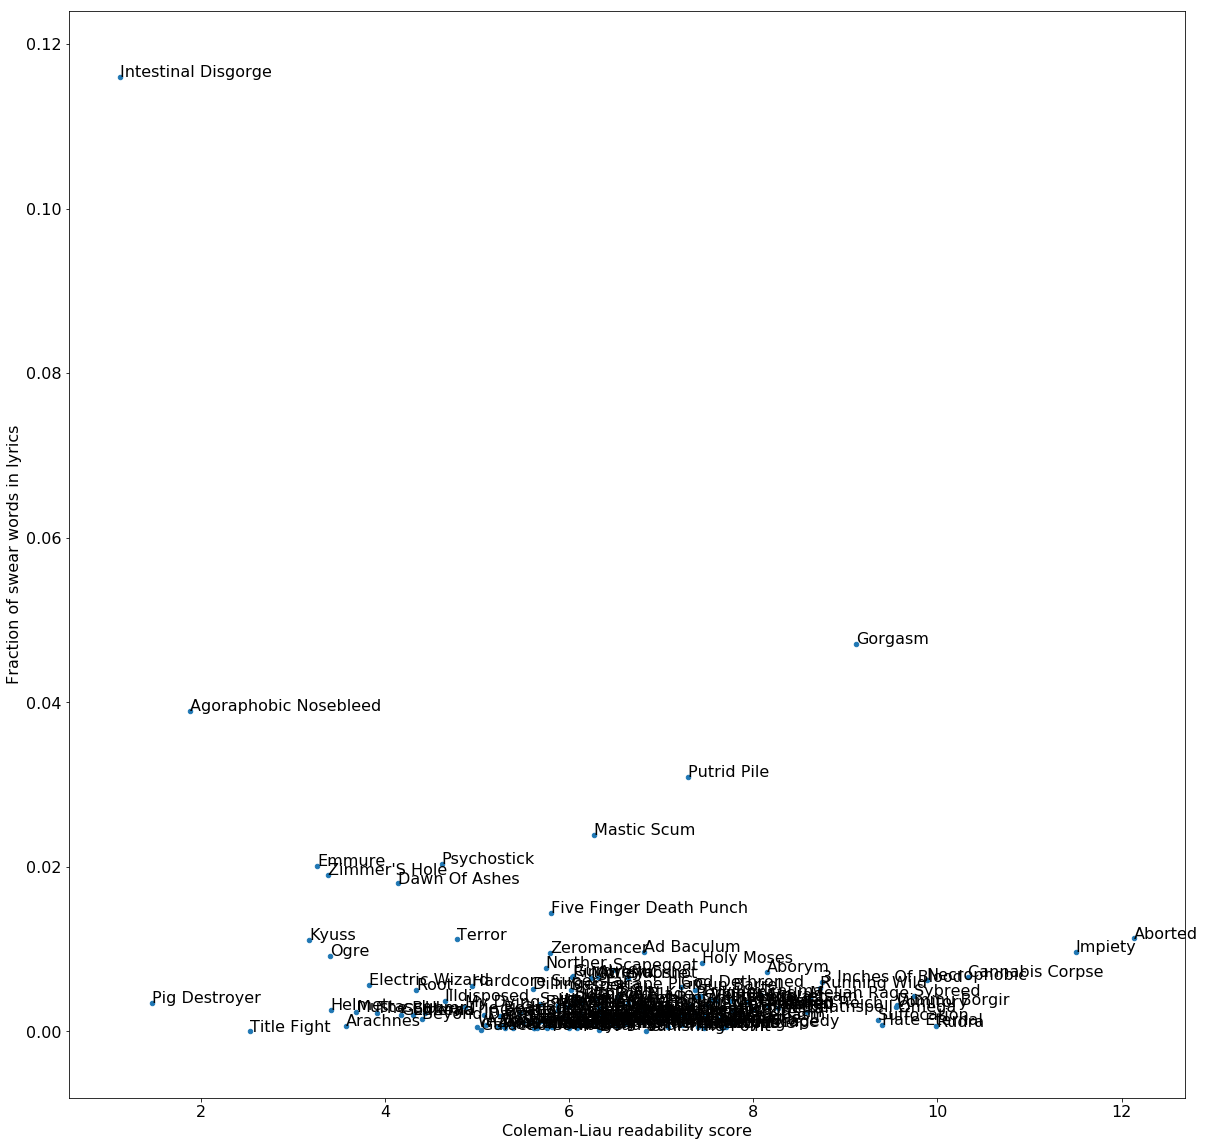

In [308]:
printmd('**<p style="text-align:center">Swear words VS Readability plot of 150 random bands</p>**')
plot_scatter(
    readable_artists_df.sample(n=150, random_state=50),
    x="average_readability_index",
    y="average_swear_word_ratio",
    xlabel="Coleman-Liau readability score",
    ylabel="Fraction of swear words in lyrics",
    figsize=(20, 20),
    labels="artist",
    title="Swear words index against Coleman-L readability score"
)

### Readability over time

In [276]:
temp_df = popular_bands_df.groupby(['release_year']).agg({
    'swear_word_ratio': ['mean'], 
    'readability': ['mean']
}, axis="columns").reset_index()
readability_swear_time = pd.DataFrame({
    "release_year": temp_df[('release_year', '')],
    "average_swear_word_ratio": temp_df[('swear_word_ratio', 'mean')],
    "average_readability_index": temp_df[('readability', 'mean')]
})

printmd("**First 10 years with highest swearwords ratio**")
display(HTML(readability_swear_time.sort_values(['average_swear_word_ratio'], ascending=False)[:10].to_html()))
printmd("**First 10 years with lower readability ratio**")
display(HTML(readability_swear_time.sort_values(['average_readability_index'], ascending=True)[:10].to_html()))

**First 10 years with highest swearwords ratio**

,release_year,average_swear_word_ratio,average_readability_index
28,1997,0.006362,5.970214
38,2007,0.006198,6.288457
34,2003,0.006163,6.418037
27,1996,0.006068,5.854736
16,1985,0.005761,6.635930
37,2006,0.005464,6.409549
36,2005,0.005453,6.252714
25,1994,0.005395,5.712522
18,1987,0.005254,6.832761
39,2008,0.005145,6.634763


**First 10 years with lower readability ratio**

,release_year,average_swear_word_ratio,average_readability_index
5,1974,0.001398,4.187500
0,1969,0.000000,4.210526
1,1970,0.000552,4.791667
12,1981,0.003326,5.241379
6,1975,0.000195,5.677419
25,1994,0.005395,5.712522
13,1982,0.004062,5.809365
8,1977,0.001496,5.833333
27,1996,0.006068,5.854736
11,1980,0.003318,5.891892


**<p style="text-align: center;">Evolution of average swear words ratio in metal lyrics</p>**

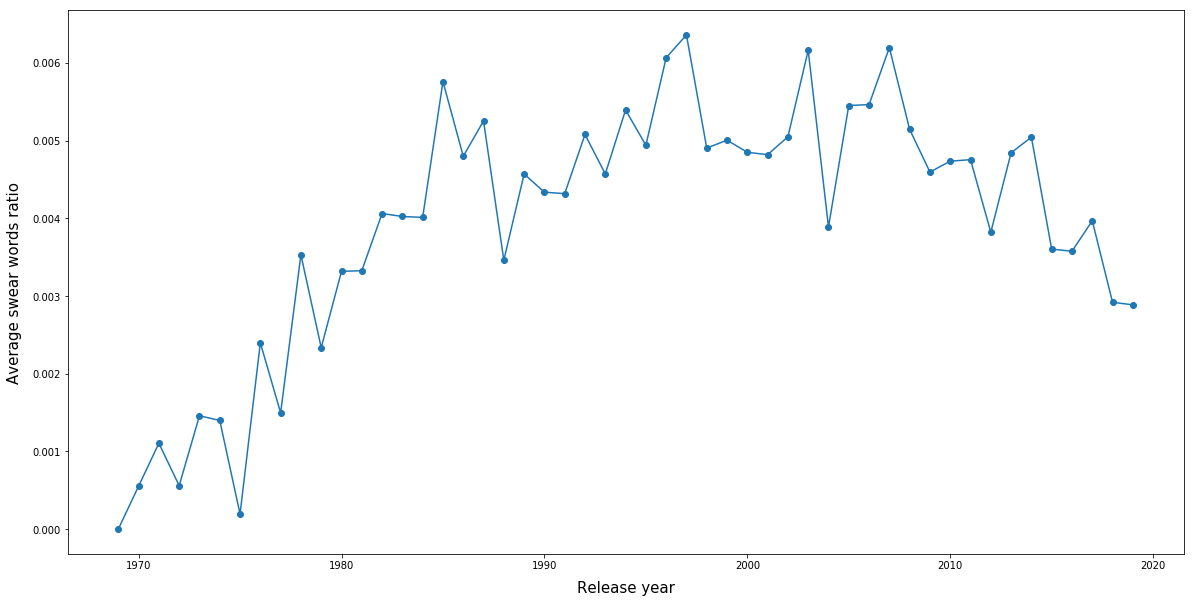

**<p style="text-align: center;">Evolution of average Coleman-Liau score of metal lyrics</p>**

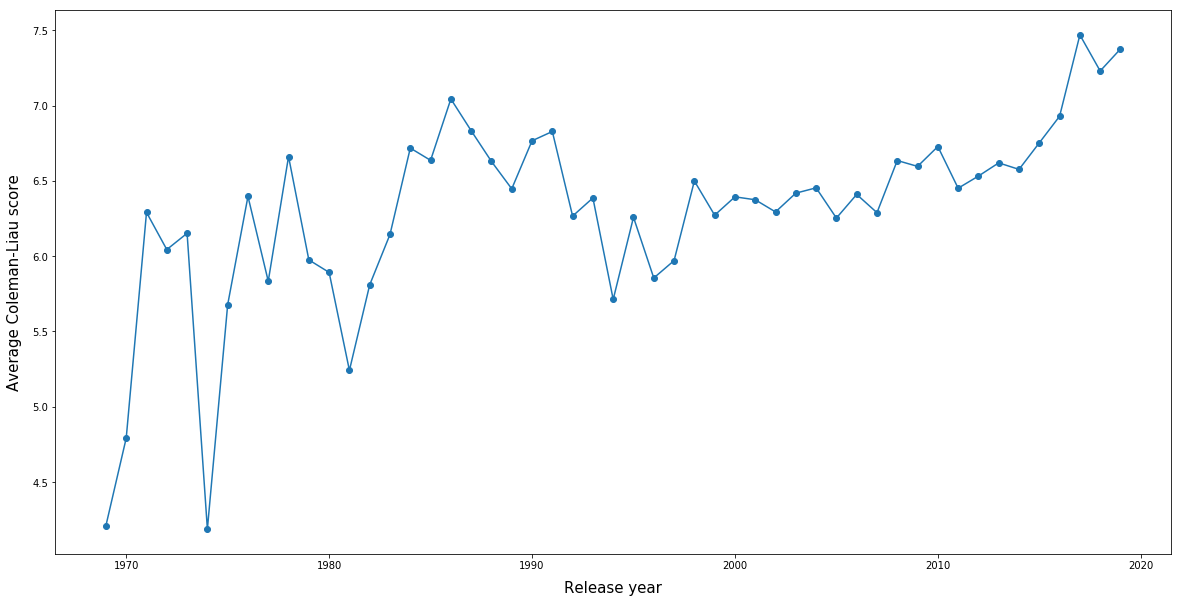

In [340]:
printmd('**<p style="text-align: center;">Evolution of average swear words ratio in metal lyrics</p>**')
plot_connected_scatter(
    data=[readability_swear_time],
    x='release_year',
    xlabel='Release year',
    y='average_swear_word_ratio',
    ylabel='Average swear words ratio',
    figsize=(20, 10),
)

printmd('**<p style="text-align: center;">Evolution of average Coleman-Liau score of metal lyrics</p>**')
plot_connected_scatter(
    data=[readability_swear_time],
    x='release_year',
    xlabel='Release year',
    y='average_readability_index',
    ylabel='Average Coleman-Liau score',
    figsize=(20, 10),
)

**<p style="text-align: center;">Proportionality between swear word ratio and percent of "stupid songs"</p>**

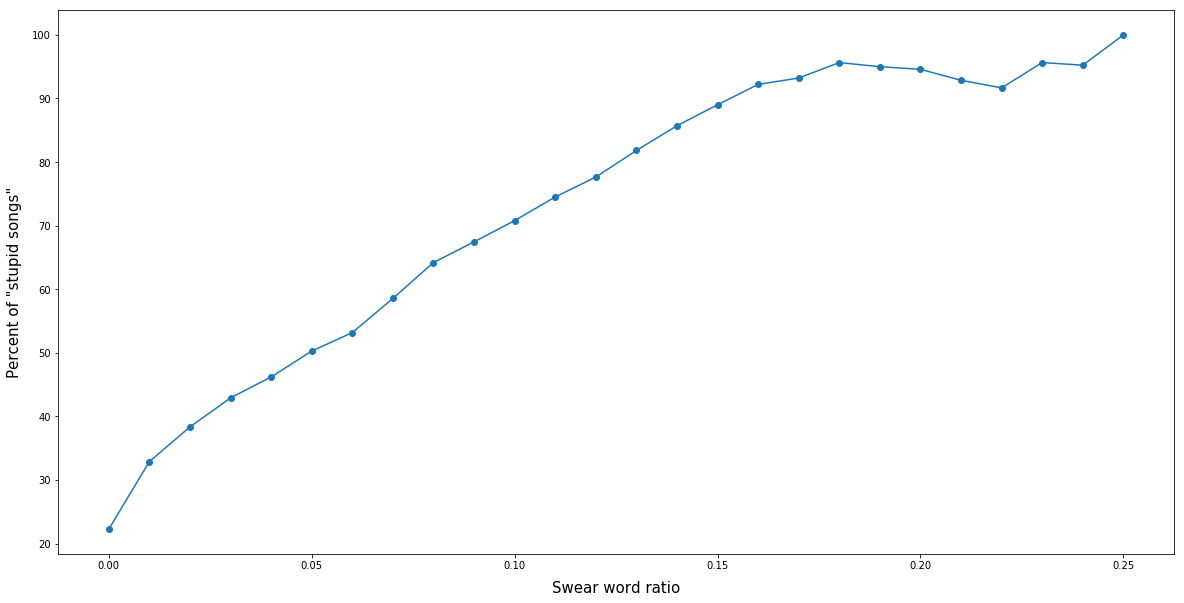

,swear_word_ratio,stupid_songs_perc
0,0.00,22.27
1,0.01,32.89
2,0.02,38.34
3,0.03,42.91
4,0.04,46.20
5,0.05,50.27
6,0.06,53.17
7,0.07,58.55
8,0.08,64.20
9,0.09,67.45


In [345]:
def get_percent_stupid_songs(swear_word_ratio):
    stupidity_threshold = 3
    
    swear_words_songs = popular_bands_df[popular_bands_df["swear_word_ratio"] >= swear_word_ratio]
    num_stupid_songs = swear_words_songs[swear_words_songs["readability"] <= stupidity_threshold]
    percent_stupid_songs = round((100 * len(num_stupid_songs) / len(swear_words_songs)), 2)
    
    return percent_stupid_songs

stupid_ratio = {'swear_word_ratio': [], 'stupid_songs_perc': []}
for ratio in np.arange(0.00, 0.26, 0.01):
    stupid_ratio['swear_word_ratio'].append(ratio)
    stupid_ratio['stupid_songs_perc'].append(get_percent_stupid_songs(ratio))

printmd('**<p style="text-align: center;">Proportionality between swear word ratio and percent of "stupid songs"</p>**')
plot_connected_scatter(
    data=[pd.DataFrame.from_dict(stupid_ratio)],
    x='swear_word_ratio',
    xlabel='Swear word ratio',
    y='stupid_songs_perc',
    ylabel='Percent of "stupid songs"',
    figsize=(20, 10),
)
    
pd.DataFrame.from_dict(stupid_ratio)

    

## Word frequence

- Calculate the distribution of most frequent words in the dataset, excluding stopwords and punctuation;
- Display a wordcloud of the 200 most common words;

In [216]:
def get_word_frequence_distribution(df, text_column):
    words_corpus = " ".join(df[text_column].astype(str).values)
    words_corpus = words_corpus.lower().replace('\\n', ' ')
    word_freq_dist = FreqDist(nltk.word_tokenize(words_corpus))

    # remove punctuation and stopwords
    for stopword in STOPWORDS:
        if stopword in word_freq_dist:
            del word_freq_dist[stopword]

    for punctuation in PUNCTUATION:
        if punctuation in word_freq_dist:
            del word_freq_dist[punctuation]
            
    return word_freq_dist

**Cloud of the 200 most common words in the dataset**

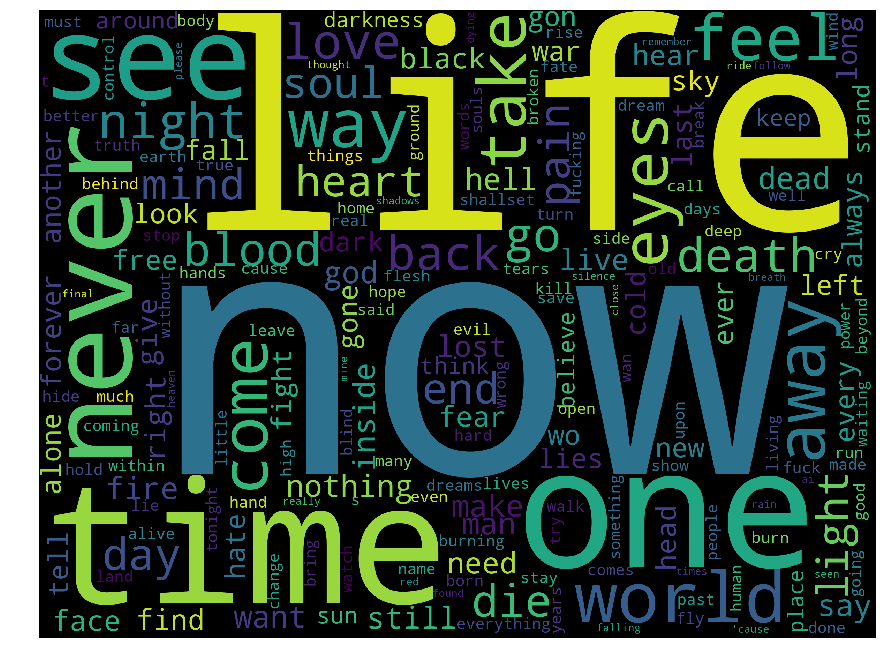

In [346]:
metal_word_freq_dist = get_word_frequence_distribution(popular_bands_df, 'lyrics')

printmd('**Cloud of the 200 most common words in the dataset**')
plot_wordcloud(
    metal_word_freq_dist.most_common(200),
    width=800,
    height=600,
    figsize=(15,20),
    scale=3,
)

### Bands confrontation

Display the word cloud for 4 bands of different subgeneres:
- Dream Theater (prog)
- Slayer (thrash)
- Manowar (epic)
- Cannibal Corpse (brutal death)

<img src="common/resources/img/dt.jpg">

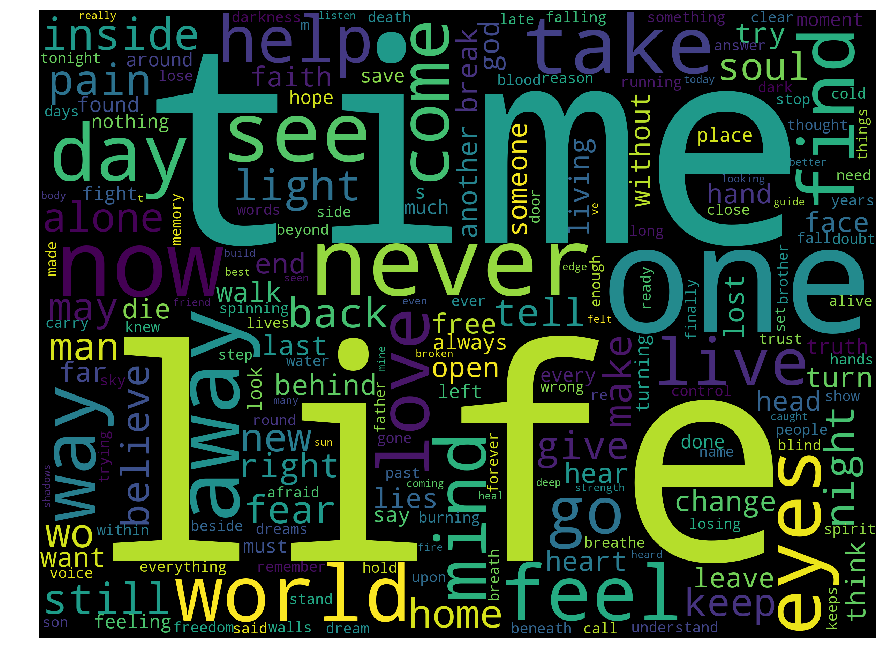

In [218]:
dt_word_freq_dist = get_word_frequence_distribution(
    popular_bands_df[popular_bands_df.artist == "Dream Theater"], 
    'lyrics'
)

plot_wordcloud(
    dt_word_freq_dist.most_common(200),
    width=800,
    height=600,
    figsize=(15,20),
    scale=3,
)

<img src="common/resources/img/slayer.jpg">

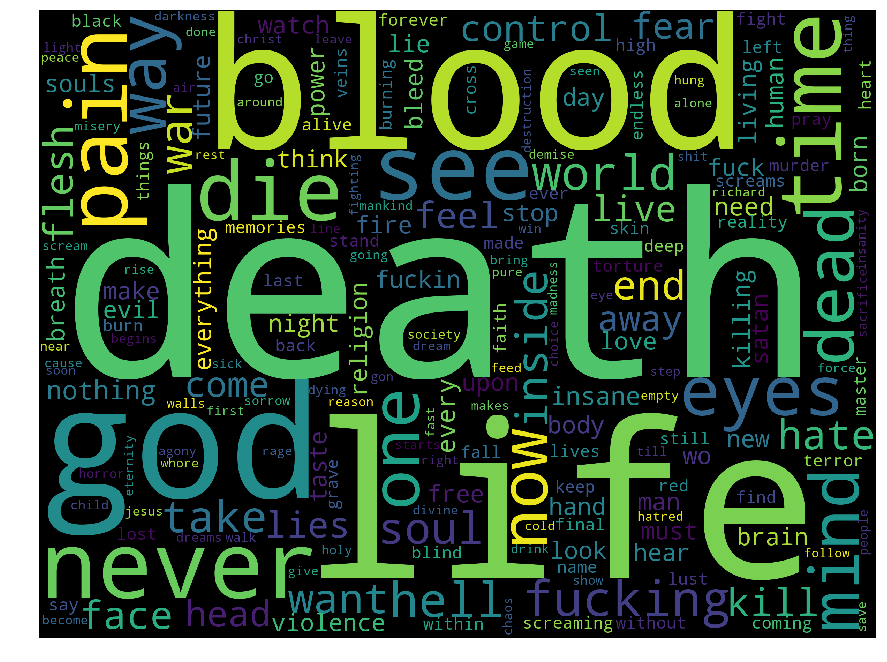

In [219]:
slayer_word_freq_dist = get_word_frequence_distribution(
    popular_bands_df[popular_bands_df.artist == "Slayer"], 
    'lyrics'
)

plot_wordcloud(
    slayer_word_freq_dist.most_common(200),
    width=800,
    height=600,
    figsize=(15,20),
    scale=3,
)

<img src="common/resources/img/manowar.jpg">

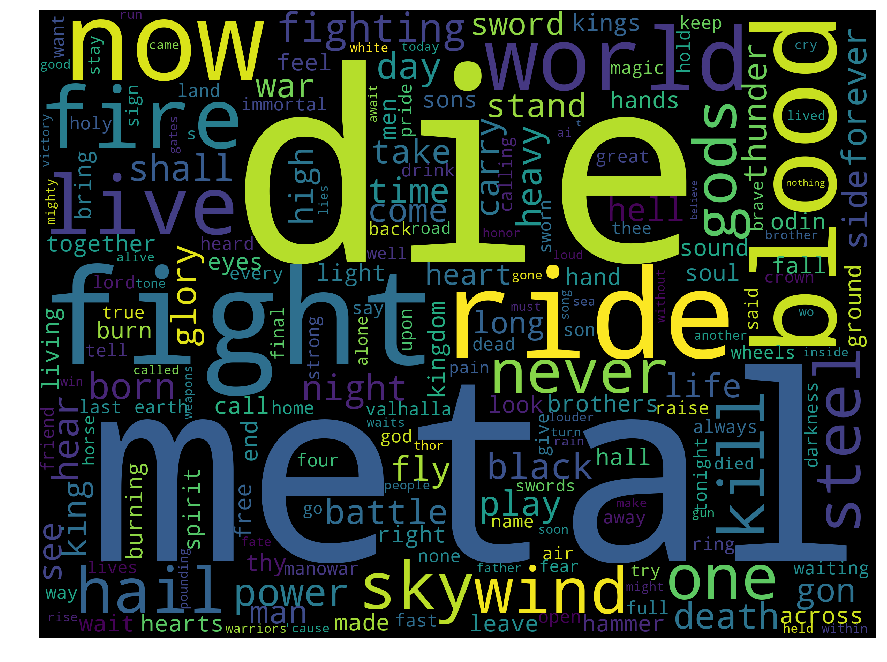

In [220]:
manowar_word_freq_dist = get_word_frequence_distribution(
    popular_bands_df[popular_bands_df.artist == "Manowar"], 
    'lyrics'
)

plot_wordcloud(
    manowar_word_freq_dist.most_common(200),
    width=800,
    height=600,
    figsize=(15,20),
    scale=3,
)

<img src="common/resources/img/cannibalcorpse.jpg">

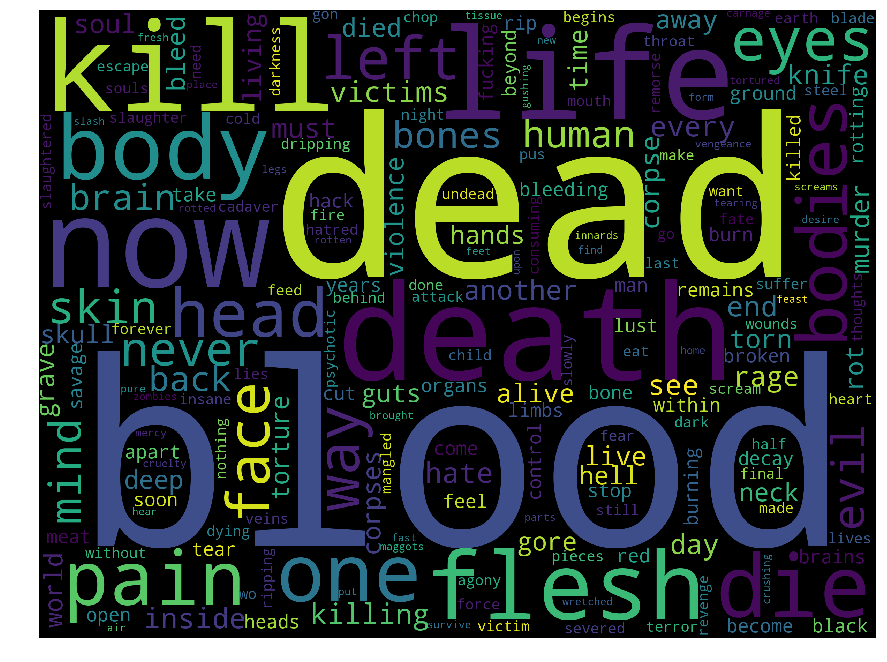

In [221]:
cannibalcorpse_word_freq_dist = get_word_frequence_distribution(
    popular_bands_df[popular_bands_df.artist == "Cannibal Corpse"], 
    'lyrics'
)

plot_wordcloud(
    cannibalcorpse_word_freq_dist.most_common(200),
    width=800,
    height=600,
    figsize=(15,20),
    scale=3,
)

## Mining metal...
- Retrieve a dataset of non-metal songs and extract the most common words;
- Define an "index of metalness" for each word
- Individuate the most/less metal words, songs, studio albums and artists

### Extract most common words on non-metal songs

In [312]:
no_metal_dataset_eng_df = pd.read_csv('../datasets/non_metal_dataset_clean_eng.csv', encoding='utf-8', sep='|', dtype=str)
no_metal_dataset_eng_df.head()

print("Songs in the dataset: " + str(len(no_metal_dataset_eng_df)))

Songs in the dataset: 97451


In [223]:
no_metal_word_freq_dist = get_word_frequence_distribution(no_metal_dataset_eng_df, 'lyrics')

### Wordcloud of the 200 most common words on non-metal lyrics dataset

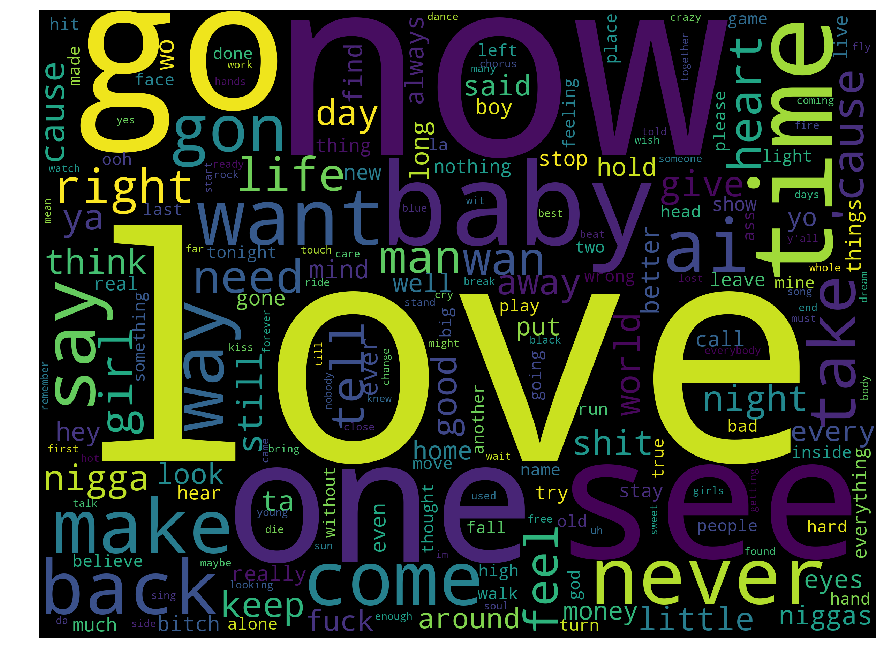

In [224]:
plot_wordcloud(
    no_metal_word_freq_dist.most_common(200),
    width=800,
    height=600,
    figsize=(15,20),
    scale=3,
)

### Define an "index of metalness" and calculate it for each word

Given

$WordFreq_m$ = the frequence of a word in the metal dataset,<br />
$WordFreq_n$ = the frequence of a word in the NOT metal dataset<br />

and 

$N_m$ = the number of words in the word frequence table of the metal dataset<br />
$N_n$ = the number of words in the word frequence table of the NOT metal dataset<br />

then can we define the "metalness" $M_s$ as the sigmoid of a metal coefficient $M_i$:

$$M_s =  \frac{1}{1 + e^{-\frac{M_i}{2}}}$$

where $M_i$ is defined by:

$$M_i = log(\frac{\frac{WordFreq_m}{N_m}}{\frac{WordFreq_n}{N_n}})$$

In [225]:
def calculate_words_metalness(metal_wfd, no_metal_wfd):
    no_metal_wfd = {k:v for k,v in no_metal_wfd.items() if v >= 5}
    num_no_metal_words = sum(no_metal_wfd.values())

    metal_wfd = {k:v for k,v in metal_wfd.items() if v >= 5}
    num_metal_words = sum(metal_wfd.values())

    metalness = {}
    for w in metal_wfd.keys() & no_metal_wfd.keys():
        if len(w) > 2:
            metal_coefficient = math.log((metal_wfd[w] / num_metal_words) / (no_metal_wfd[w] / num_no_metal_words))
            metalness[w] = 1 / (1 + math.exp(-metal_coefficient / 2))
            
    metalness_df = pd.DataFrame({
        'words': list(metalness.keys()),
        'metalness': list(metalness.values())
    })
            
    return metalness_df

In [226]:
words_metalness_df = calculate_words_metalness(metal_word_freq_dist, no_metal_word_freq_dist) \
        .sort_values(['metalness'], ascending=False).reset_index().drop(columns=['index'])

In [227]:
printmd('**Table of the 20 most "metal" words**')
display(HTML(words_metalness_df.head(n=20).to_html()))
printmd('**Table of the 20 less "metal" words**')
display(HTML(words_metalness_df.tail(n=20).to_html()))

**Table of the 20 most "metal" words**

,words,metalness
0,valhalla,0.920496
1,hordes,0.917612
2,odin,0.906300
3,damnation,0.904388
4,invoke,0.904307
5,rites,0.902874
6,bringer,0.900375
7,aeons,0.898218
8,putrid,0.897426
9,carrion,0.897200


**Table of the 20 less "metal" words**

,words,metalness
22688,poppin,0.101128
22689,killa,0.100906
22690,yah,0.099281
22691,wit,0.098810
22692,uh-huh,0.094918
22693,homies,0.092036
22694,wid,0.091922
22695,gots,0.091377
22696,tryna,0.088001
22697,y'all,0.085550


### Calculate metalness score for each song

In [228]:
def calculate_metalness_score(lyrics):
    lyrics = lyrics.lower().replace('\\n', ' ').strip()
    words = nltk.word_tokenize(lyrics)
    words = [word for word in words if word not in PUNCTUATION]
    words = [word for word in words if word not in STOPWORDS]
    
    if len(words) == 0:
        return 0
    
    song_score = 0
    for word in words:
        if len(words_metalness_df.loc[words_metalness_df['words'] == word, 'metalness'].values) == 0:
            song_score += 0
        else:
            song_score += float(words_metalness_df.loc[words_metalness_df['words'] == word, 'metalness'].values[0])
        
    return song_score / len(words)

In [349]:
popular_bands_df.sort_values(['metalness'], ascending=False).reset_index().drop(columns=['index']).head()

,artist,album,album_type,release_year,title,track_no,lyrics,swear_word_ratio,readability,metalness
0,Exhumed,Horror,Studio,2019,Utter Mutilation of Your Corpse,5,Utter mutilation of your corpse!,0.0,1,0.799075
1,I Declare War,Amidst The Bloodshed,Studio,2007,Amidst The Bloodshed,1,Amidst the bloodshed,0.0,1,0.778127
2,Emperor,Scattered Ashes - A Decade Of Emperial Wrath,Studio,2003,I Am,19,I am the Emperor!,0.0,1,0.775466
3,Slipknot,We Are Not Your Kind,Studio,2019,Death Because Of Death,4,Death because of death because of you\nDeath b...,0.0,1,0.760939
4,Debauchery,Kill Maim Burn,Studio,2003,Hordes Of Chaos,3,We fight battles in the chaos waste\nCrushing ...,0.0,1,0.745246


### Statistics based on metalness per band

In [231]:
temp_df = popular_bands_df[popular_bands_df['album_type'] == 'Studio'].groupby(['artist']).agg({
    'metalness': ['mean']
}, axis="columns").reset_index()
metalness_artists_df = pd.DataFrame({
    "artist": temp_df[('artist', '')],
    "average_metalness_index": temp_df[('metalness', 'mean')]
})

printmd("**First 10 bands with highest metalness index**")
display(HTML(metalness_artists_df.sort_values(['average_metalness_index'], ascending=False)[:10].to_html()))
printmd("**First 10 bands with lowest metalness index**")
display(HTML(metalness_artists_df.sort_values(['average_metalness_index'], ascending=True)[:10].to_html()))

**First 10 bands with highest metalness index**

,artist,average_metalness_index
768,Sathanas,0.644002
471,Inquisition,0.633644
196,Cianide,0.632731
803,Skeletonwitch,0.632308
394,Goatwhore,0.629879
964,Vomitory,0.629106
608,Mortician,0.624371
601,Monstrosity,0.621903
421,Hate Eternal,0.621302
38,All Out War,0.620534


**First 10 bands with lowest metalness index**

,artist,average_metalness_index
51,Anal Cunt,0.398109
830,Steel Panther,0.414573
716,Psychostick,0.425166
140,Body Count,0.428722
514,Kix,0.431722
145,Botanist,0.433885
381,Fu Manchu,0.434777
527,Lacrimosa,0.439268
258,Deez Nuts,0.443084
618,Mustasch,0.445638


### Statistics based on metalness per studio album

In [351]:
temp_df = popular_bands_df[popular_bands_df['album_type'] == 'Studio'].groupby(['artist', 'album', 'release_year']).agg({
    'metalness': ['mean']
}, axis="columns").reset_index()
metalness_albums_df = pd.DataFrame({
    "artist": temp_df[('artist', '')],
    "album": temp_df[('album', '')],
    "release_year": temp_df[('release_year', '')],
    "average_metalness_index": temp_df[('metalness', 'mean')]
})

printmd("**First 20 studio albums with highest metalness index**")
display(HTML(metalness_albums_df.sort_values(['average_metalness_index'], ascending=False)[:20].to_html()))
printmd("**First 20 studio albums with lowest metalness index**")
display(HTML(metalness_albums_df.sort_values(['average_metalness_index'], ascending=True)[:20].to_html()))

**First 20 studio albums with highest metalness index**

,artist,album,release_year,average_metalness_index
1381,Centinex,Apocalyptic Armageddon,2000,0.674879
5945,Sathanas,Crowned Infernal,2007,0.664412
3495,Incantation,Blasphemy,2002,0.662876
4931,Night In Gales,The Last Sunsets,2018,0.662763
7511,Vomitory,"Terrorize, Brutalize, Sodomize",2007,0.656006
5949,Sathanas,Thy Dark Heavens,2001,0.653982
3502,Incantation,Primordial Domination,2006,0.652289
2618,Exciter,"Thrash, Speed, Burn",2008,0.652095
3497,Incantation,Diabolical Conquest,1998,0.650742
5820,Runemagick,Darkness Death Doom,2003,0.649149


**First 20 studio albums with lowest metalness index**

,artist,album,release_year,average_metalness_index
2504,Enslaved,Vikingligr veldi,1993,0.237219
4159,Loudness,Biosphere,2002,0.254985
4011,Laibach,Nova Akropola,1985,0.277964
2609,Excelsis,Tod U Vergäutig,2015,0.283970
2395,Elend,A World In Their Screams,2007,0.286322
2496,Enslaved,Frost,1994,0.289607
4280,Mandragora Scream,Fairy Tales From Hell's Caves,2001,0.291447
2495,Enslaved,Eld,1997,0.291716
7294,Ulver,The Madrigal Of The Night: Eight Hymnes To The Wolf In Man,1997,0.300244
7288,Ulver,Bergtatt - Et Eeventyr I 5 Capitler,1995,0.309083


### Bands confrontation: evolution of "metalness"
- Metallica
- Iron Maiden
- Gamma Ray

In [358]:
metalness_ml_df = metalness_albums_df[metalness_albums_df['artist'] == 'Metallica'].sort_values(['release_year'], ascending=True)
metalness_im_df = metalness_albums_df[metalness_albums_df['artist'] == 'Iron Maiden'].sort_values(['release_year'], ascending=True)
metalness_gr_df = metalness_albums_df[metalness_albums_df['artist'] == 'Gamma Ray'].sort_values(['release_year'], ascending=True)

**<p style="text-align: center;">Evolution of bands "metalness" through the years</p>**

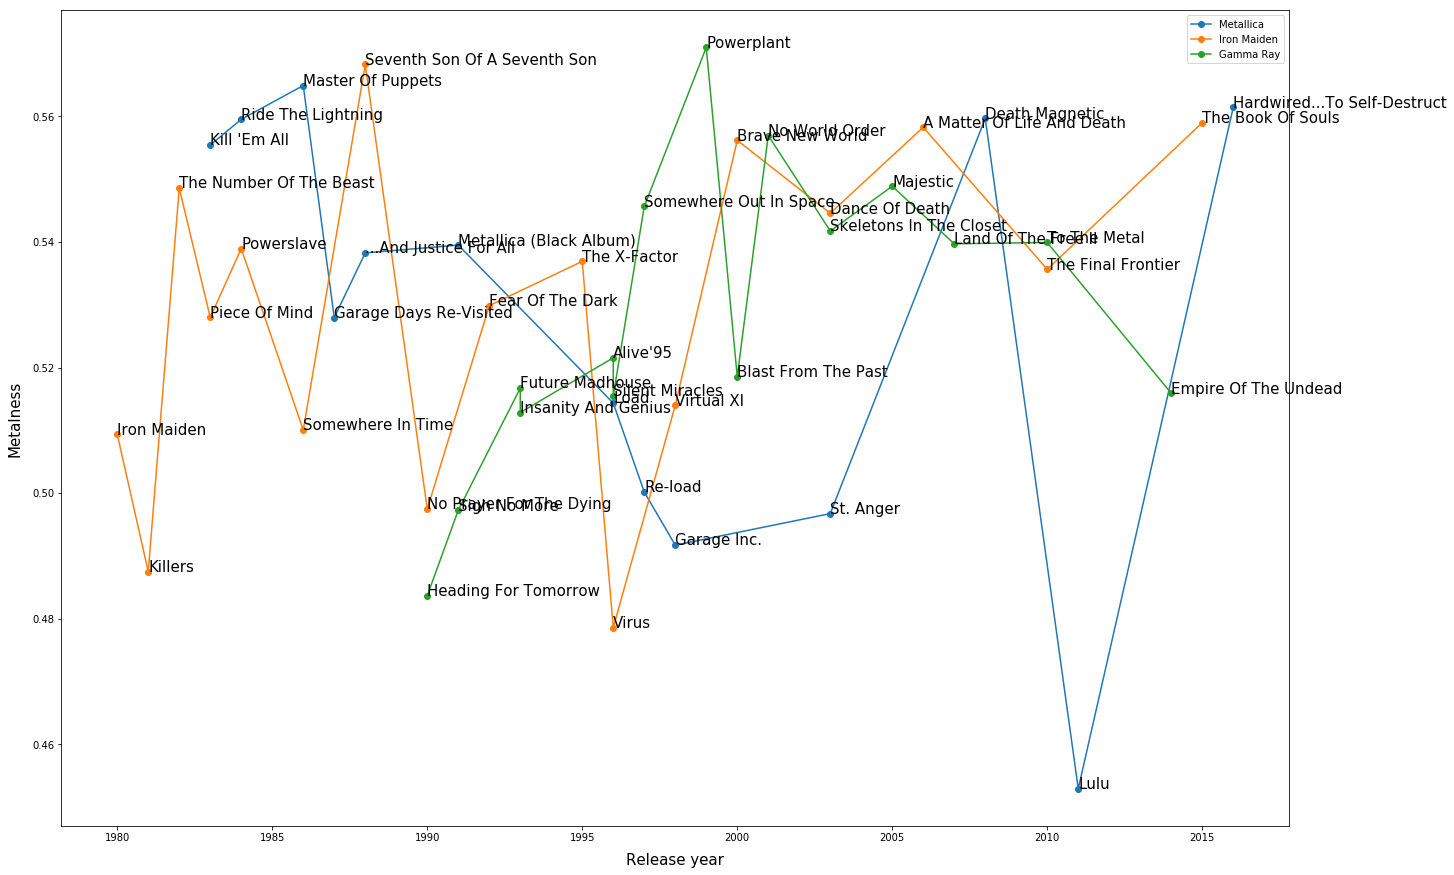

In [359]:
printmd('**<p style="text-align: center;">Evolution of bands "metalness" through the years</p>**')
plot_connected_scatter(
    data=[metalness_ml_df, metalness_im_df, metalness_gr_df],
    x='release_year',
    xlabel='Release year',
    y='average_metalness_index',
    ylabel='Metalness',
    figsize=(22, 15),
    legend=['Metallica', 'Iron Maiden', 'Gamma Ray'],
    annotation_field='album'
)

### The most metal years

In [360]:
temp_df = popular_bands_df.groupby(['release_year']).agg({
    'metalness': ['mean']
}, axis="columns").reset_index()
metalness_years_df = pd.DataFrame({
    "release_year": temp_df[('release_year', '')],
    "average_metalness_index": temp_df[('metalness', 'mean')]
}).sort_values(['release_year'], ascending=True).reset_index().drop(columns=['index'])

In [364]:
printmd("**First 10 years with highest metalness index**")
display(HTML(metalness_years_df.sort_values(['average_metalness_index'], ascending=False)[:10].to_html()))

**First 10 years with highest metalness index**

,release_year,average_metalness_index
50,2019,0.545729
49,2018,0.542571
47,2016,0.539517
39,2008,0.539499
48,2017,0.539170
35,2004,0.537909
34,2003,0.537836
32,2001,0.537346
41,2010,0.536510
37,2006,0.536423


**<p style="text-align: center;">Evolution of average "metalness" of metal lyrics through the years</p>**

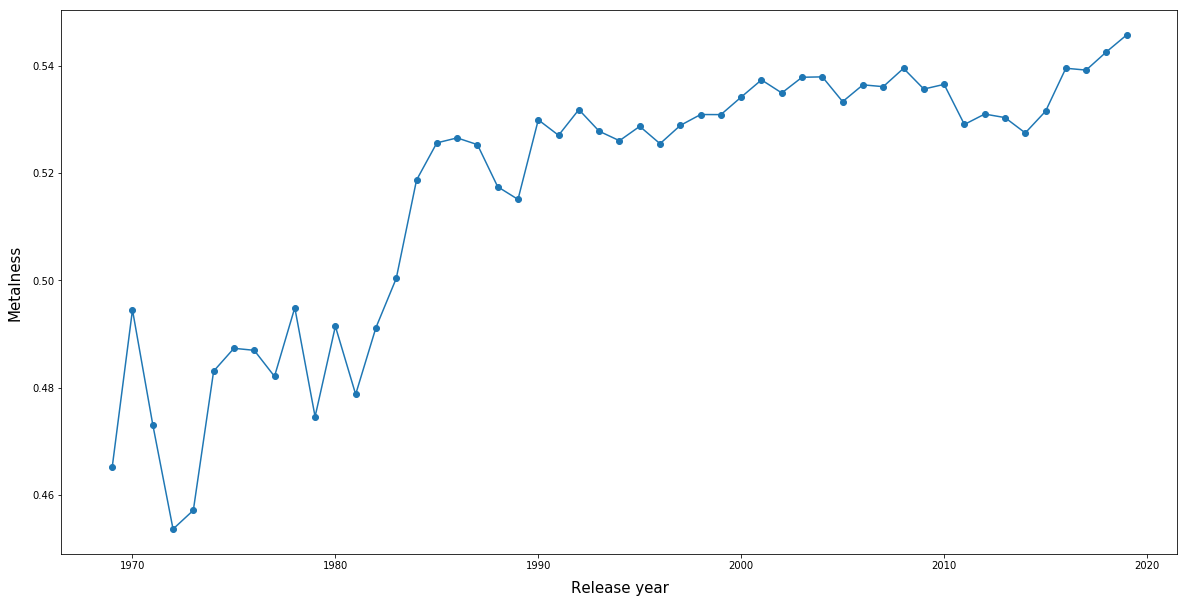

In [362]:
printmd('**<p style="text-align: center;">Evolution of average "metalness" of metal lyrics through the years</p>**')
plot_connected_scatter(
    data=[metalness_years_df],
    x='release_year',
    xlabel='Release year',
    y='average_metalness_index',
    ylabel='Metalness',
    figsize=(20, 10),
)

## Parts-Of-Sentence analysis

In [365]:
def get_pos_tags_counts(df, text_column):
    words_corpus = " ".join(df[text_column].astype(str).values)
    words_corpus = words_corpus.lower().replace('\\n', ' ')
    tokens = nltk.word_tokenize(words_corpus)
    tags = nltk.pos_tag(tokens)
    counts = Counter(tag for word, tag in tags)
            
    return counts

tags_descriptions = {
    'CC': 'coordinating conjunction',
    'CD': 'cardinal digit',
    'DT': 'determiner',
    'EX': 'existential there (like: “there is” … think of it like “there exists”)',
    'FW': 'foreign word',
    'IN': 'preposition/subordinating conjunction',
    'JJ': 'adjective',
    'JJR': 'adjective, comparative',
    'JJS': 'adjective, superlative',
    'LS': 'list marker',
    'MD': 'verb, modal',
    'NN': 'noun, singular',
    'NNS': 'noun, plural',
    'NNP': 'noun, proper singular ‘Harrison’',
    'NNPS': 'noun, proper plural ‘Americans’',
    'PDT': 'predeterminer',
    'POS': 'ending, possessive (saxon genitive etc.)',
    'PRP': 'pronoun, personal',
    'PRP$': 'pronoun, possessive',
    'RB': 'adverb',
    'RBR': 'adverb, comparative',
    'RBS': 'adverb, superlative',
    'RP': 'particle',
    'TO': 'preposition, to',
    'UH': 'interjection',
    'VB': 'verb, base form',
    'VBD': 'verb, past tense',
    'VBG': 'verb, gerund/present participle',
    'VBN': 'verb, past participle',
    'VBP': 'verb, sing. present, non-3d ',
    'VBZ': 'verb, 3rd person sing. present',
    'WDT': 'wh-determiner (which)',
    'WP': 'wh-pronoun (who, what)',
    'WP$': 'wh-pronoun, possessive (whose)',
    'WRB': 'wh-abverb (where, when)',
    '.': 'punctuation'
}


def cleanup_tags_freq_dict(tags_dist):
    misc = 0
    to_delete = []
    tags_dict = dict(tags_dist)
    
    for key in tags_dict.keys():
        if key not in tags_descriptions.keys():
            misc += int(tags_dict[key])
            to_delete.append(key)            
    for key in to_delete:
        del tags_dict[key]
            
    tags_dict['MISC'] = misc
            
    return tags_dict


def aggregate_pos_counts(df):
    nouns = df[(df['description'].str.contains('noun')) & (~df['description'].str.contains('pronoun'))].agg({'values': 'sum'})
    verbs = df[(df['description'].str.contains('verb')) & (~df['description'].str.contains('adverb'))].agg({'values': 'sum'})
    adverbs = df[(df['description'].str.contains('adverb'))].agg({'values': 'sum'})
    adjectives = df[(df['description'].str.contains('adjective'))].agg({'values': 'sum'})
    pronouns = df[(df['description'].str.contains('pronoun'))].agg({'values': 'sum'})
    prepositions = df[(df['description'].str.contains('preposition')) & (~df['description'].str.contains('conjuction'))].agg({'values': 'sum'})
    conjunctions = df[(df['description'].str.contains('conjunction')) & (~df['description'].str.contains('preposition'))].agg({'values': 'sum'})
    interjections = df[(df['description'].str.contains('interjection'))].agg({'values': 'sum'})
    determiners = df[(df['description'].str.contains('determiner'))].agg({'values': 'sum'})
    foreign_words = df[(df['description'].str.contains('foreign word'))].agg({'values': 'sum'})
    punctuation_symbols = df[(df['description'].str.contains('list marker')) | (df['description'].str.contains('punctuation')) | (df['description'].str.contains('unidentified symbols'))].agg({'values': 'sum'})

    return {
        'nouns': int(nouns),
        'verbs': int(verbs),
        'adverbs': int(adverbs),
        'adjectives': int(adjectives),
        'pronouns': int(pronouns),
        'prepositions': int(prepositions),
        'conjunctions': int(conjunctions),
        'interjections': int(interjections),
        'determiners': int(determiners),
        'foreign words': int(foreign_words),
        'punctuation/symbols': int(punctuation_symbols)
    }

In [366]:
metal_pos_tags_dist = get_pos_tags_counts(dataset_eng_df, 'lyrics')

In [367]:
metal_pos_tags_dict = cleanup_tags_freq_dict(metal_pos_tags_dist)

In [368]:
non_metal_pos_tags_dist = get_pos_tags_counts(no_metal_dataset_eng_df, 'lyrics')

In [369]:
non_metal_pos_tags_dict = cleanup_tags_freq_dict(non_metal_pos_tags_dist)

In [370]:
tags_descriptions['MISC'] = 'unidentified symbols'
metal_pos_df = pd.DataFrame({
    'tags': list(metal_pos_tags_dict.keys()),
    'values': list(metal_pos_tags_dict.values()),
    'description': [tags_descriptions[key] for key in list(metal_pos_tags_dict.keys())]
}).sort_values(['values'], ascending=False).reset_index().drop(columns=['index'])
non_metal_pos_df = pd.DataFrame({
    'tags': list(non_metal_pos_tags_dict.keys()),
    'values': list(non_metal_pos_tags_dict.values()),
    'description': [tags_descriptions[key] for key in list(non_metal_pos_tags_dict.keys())]
}).sort_values(['values'], ascending=False).reset_index().drop(columns=['index'])

In [371]:
printmd('**<p style="text-align:center">POS distribution in metal dataset</p>**')
metal_pos_df

**<p style="text-align:center">POS distribution in metal dataset</p>**

,tags,values,description
0,NN,6647644,"noun, singular"
1,IN,3418276,preposition/subordinating conjunction
2,DT,3263355,determiner
3,JJ,2416168,adjective
4,PRP,2224314,"pronoun, personal"
5,VB,2114218,"verb, base form"
6,VBP,1861650,"verb, sing. present, non-3d"
7,RB,1795857,adverb
8,NNS,1634063,"noun, plural"
9,MISC,1610774,unidentified symbols


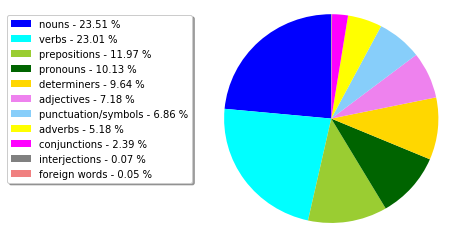

In [372]:
metal_pos_dict_df = pd.DataFrame({
    'pos': list(aggregate_pos_counts(metal_pos_df).keys()),
    'count': list(aggregate_pos_counts(metal_pos_df).values())
}).sort_values(['count'], ascending=False).reset_index().drop(columns=['index'])
plot_pie_graph(
    x=metal_pos_dict_df['pos'],
    y=metal_pos_dict_df['count'],
    title='POS tags distribution for metal dataset',
    figsize=(4, 4), 
    labels=list(metal_pos_dict_df['pos']), 
    labeldistance=0,
    pctdistance=0.5,
    shadow=True
)

In [373]:
printmd('**<p style="text-align:center">POS distribution in NOT metal dataset</p>**')

non_metal_pos_df

**<p style="text-align:center">POS distribution in NOT metal dataset</p>**

,tags,values,description
0,NN,5426828,"noun, singular"
1,PRP,2722390,"pronoun, personal"
2,IN,2514064,preposition/subordinating conjunction
3,DT,2275816,determiner
4,VB,2221583,"verb, base form"
5,JJ,2172543,adjective
6,MISC,2165384,unidentified symbols
7,VBP,2082517,"verb, sing. present, non-3d"
8,RB,1976499,adverb
9,NNS,954290,"noun, plural"


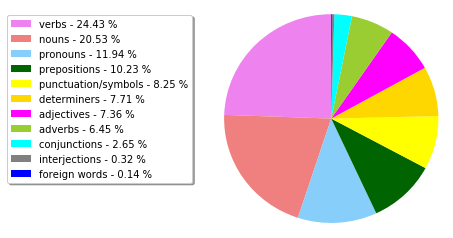

In [374]:
non_metal_pos_dict_df = pd.DataFrame({
    'pos': list(aggregate_pos_counts(non_metal_pos_df).keys()),
    'count': list(aggregate_pos_counts(non_metal_pos_df).values())
}).sort_values(['count'], ascending=False).reset_index().drop(columns=['index'])
plot_pie_graph(
    x=non_metal_pos_dict_df['pos'],
    y=non_metal_pos_dict_df['count'],
    title='POS tags distribution for metal dataset',
    figsize=(4, 4), 
    labels=list(non_metal_pos_dict_df['pos']), 
    labeldistance=0,
    pctdistance=0.5,
    shadow=True
)

In [375]:
popular_bands_df.to_csv('metal_dataset_clean_eng.csv', index=False, sep='|')